In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad= 0.0
        self._backward = lambda : None
        self._prev= set(_children)
        self._op = _op
        self.label= label
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward 
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out= Value(self.data*other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward= _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other- 1)) * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self): 
        return self *-1
    
    def __sub__(self, other): 
        return self + (-other)
    
    def __radd__(self, other): 
        return self + other

    
    def tanh(self):
        x= self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1- t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x= self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
            
        return out

    
    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad= 1.0
        for node in reversed(topo):
            node._backward()

In [3]:
from graphviz import Digraph

def trace(root):
    nodes, edges= set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot= Digraph(format='svg', graph_attr={'rankdir':'LR'})#LR= left to right
                 
    nodes, edges= trace(root)
    for n in nodes:
        uid= str(id(n))
        dot.node(name= uid, label= "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label = n._op)
            dot.edge(uid+ n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+ n2._op)
                 
    return dot

In [ ]:
#Lets do this with PyTorch

In [4]:
import torch

x1 = torch.Tensor([2.0]).double()                ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ;w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ;b.requires_grad = True
n = x1*w1 + x2*w2 + b 
o = torch.tanh(n)

print(o.data.item()) 
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

#o.item and o.data.item are the same

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [5]:
class Neuron:
    
    def __init__(self,nin):#nin = number of inputs in the cell body (number of x)
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self,x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self,nin, nout): #nout = number of neurons in a layer
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        #params = []
        #for neuron in self.neurons:
            #ps = neuron.parameters()
            #params.extend(ps)
        #return params
        #In a compact way:
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
        

class MLP:
    
    def __init__(self,nin,nouts):
        sz= [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [6]:
#Let's make an example
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])#3 input neurons, 2 layers with 4 neurons and one output neuron
n(x)

Value(data=0.7933341804039508)

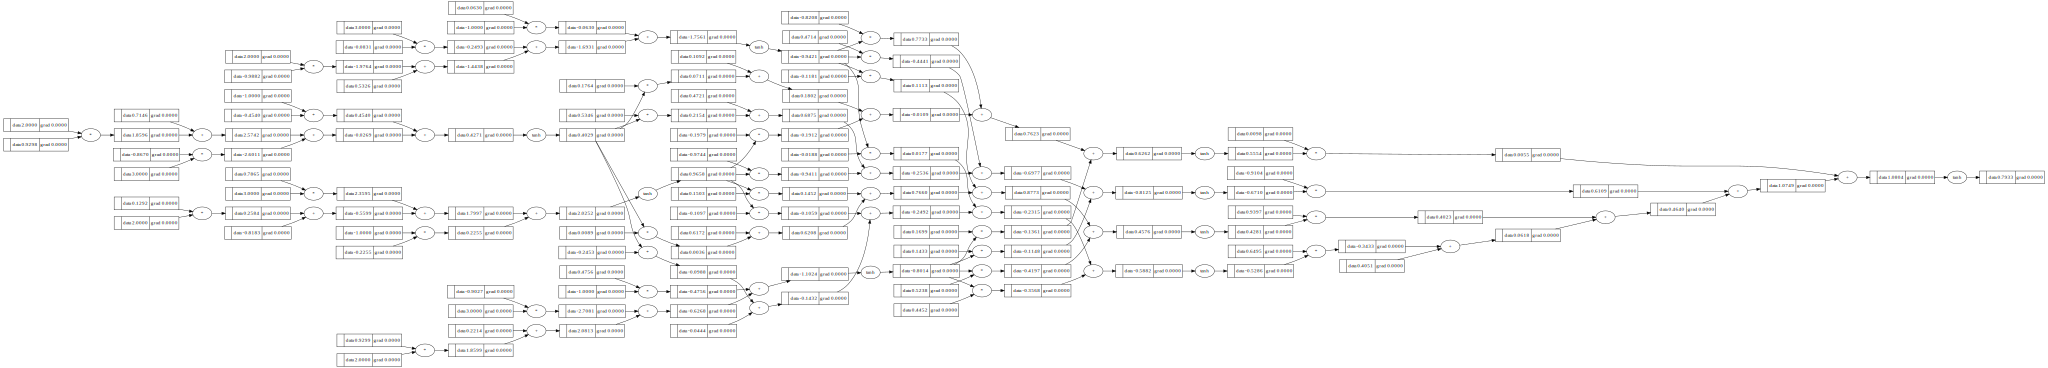

In [7]:
draw_dot(n(x))

In [8]:
#Now let's create an example dataset
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]                    
ys = [1.0, -1.0, -1.0, 1.0]#these are the desired targets

ypred = [n(x) for x in xs ]
ypred

[Value(data=0.7933341804039508),
 Value(data=0.4767036280530608),
 Value(data=0.5068497673039446),
 Value(data=0.3819415870027825)]

In [9]:
#Define the loss function to minimize
loss= sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=4.87595678919497)

In [10]:
loss.backward()

In [11]:
n.layers[0].neurons[0].w[0].grad

-0.26540876350914544

In [12]:
n.layers[0].neurons[0].w[0].data#This is the value of the neuron

0.9298169379937455

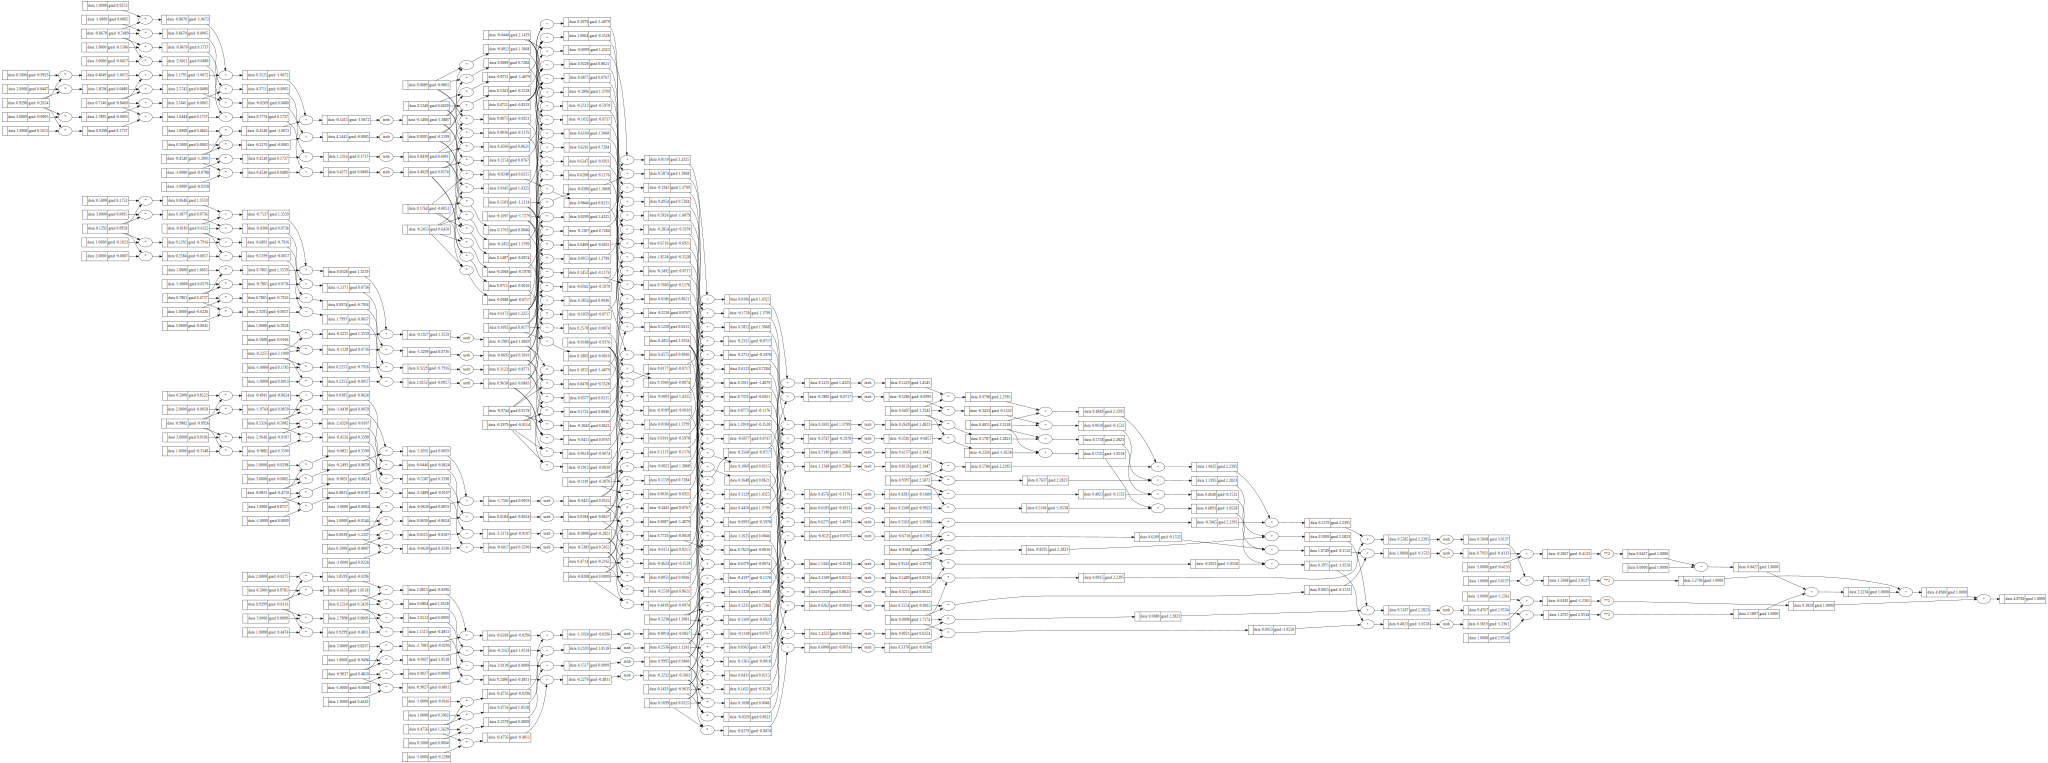

In [13]:
draw_dot(loss)

In [14]:
n.parameters()#To show weights and Bias

[Value(data=0.9298169379937455),
 Value(data=-0.867037455704408),
 Value(data=-0.45399425522875436),
 Value(data=0.7146141486196891),
 Value(data=0.1292222881816525),
 Value(data=0.7865103833135465),
 Value(data=-0.2255144023180371),
 Value(data=-0.8182992195675809),
 Value(data=-0.988211589204361),
 Value(data=-0.0830880059325243),
 Value(data=0.06303841362213491),
 Value(data=0.5326035087247305),
 Value(data=0.9299370197966559),
 Value(data=-0.9026869058261318),
 Value(data=0.4756182079775071),
 Value(data=0.22139079017998564),
 Value(data=-0.24533142823306142),
 Value(data=-0.10969354911870233),
 Value(data=-0.01879575191018934),
 Value(data=0.4451980746295632),
 Value(data=-0.04439225638248967),
 Value(data=0.008869728111949193),
 Value(data=0.150339574182343),
 Value(data=-0.11813260645875912),
 Value(data=0.5237586442725304),
 Value(data=0.6172183871038861),
 Value(data=0.5345839671217913),
 Value(data=-0.9744212007258239),
 Value(data=0.471438415152718),
 Value(data=0.1433003266

In [15]:
#This is the update function
for p in n.parameters():
    p.data += -0.1 * p.grad

In [16]:
for k in range(20):
    
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))
    
    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data)
    

0 1.629381319377519
1 0.49074303497283733
2 0.27607385829580094
3 0.21647036623330318
4 0.17922042424896792
5 0.15275263694517996
6 0.13288726467239817
7 0.11743195093948613
8 0.10507667618747406
9 0.09498324674015077
10 0.08658949622385238
11 0.07950434629316672
12 0.07344747264291931
13 0.06821281279526174
14 0.06364558814629737
15 0.05962734251344392
16 0.056065917204144264
17 0.05288856429130725
18 0.050037110803811104
19 0.04746449626814299


In [17]:
#Let's make a try
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.5431958429409919)

In [18]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]                    
ys = [1.0, -1.0, -1.0, 1.0]

In [19]:
for k in range(20):
    
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys,ypred))
    
    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data)

0 4.2149992833954215
1 2.9369418581139
2 2.643869537401267
3 1.9112896659662455
4 1.526966188937895
5 0.8648454902690405
6 0.45249746269996827
7 0.2731735546510802
8 0.21078749795506246
9 0.16888445134452384
10 0.1392481560479264
11 0.117470581668426
12 0.10095710758705495
13 0.08810422362336695
14 0.07787859835466551
15 0.06958991580194095
16 0.0627625009756557
17 0.05705969224179026
18 0.052237605134860504
19 0.0481159228589959


In [20]:
ypred

[Value(data=0.8776218632997241),
 Value(data=-0.8652309869684582),
 Value(data=-0.8888956015307304),
 Value(data=0.9486907388081801)]